# Cost Prediction for Logistic Company

## Overview

    The logistics side of a company consists of different components such as : warehousing, packaging, inventory, transportation, and information. It is important for a company to be able to predict the cost of transporting their packages from point A to point B in order for them to have a clear idea of how much they should expect to spend on transportation costs. As an accounting student, I wanted to marry my knowledge in accounting and data science by focusing on the transportation component and create a model that predicts the transportation cost based on different variables. The data that I used came from Kaggle. This dataset, although it does not consist of "real" business data was still useful in creating a predictive model. It contained 11 different variables and roughly 40,000 rows of data. I ran different models such as: linear regression, grid search, and random forest. I ended up using a random forest model, a supervised machine learning algorith, to make this predictive model. The results of this model indicated that the weight, time of day, and origin location / destination location variables were the most correlated variables with cost (the variable we want to predict). Based off of these results my recommendations would be that the company optimize time of day, optimize origin location / destination location, and although reducing the weight of each transportation seems like commom sense, it is important to not diminish its impact on transporation costs.

## Business Problem

    The business problem that I am aiming to help solve is creating a model that predicts the transportation cost based off of different variables. The internal stakeholders are the business owner and CFO. A pain point related to this project is deciding if I should drop or keep the outliers in this dataset. My deliverable is both the analysis of the models results and the model itself. The way to approach the business problem is run regression models on the data set in order to see the relationship between the independent and dependent variables. 

## Imports

In [58]:
import pandas as pd
from math import sqrt
import seaborn as sns
import statsmodels.api as sm 
import matplotlib.pyplot as plt

from time import strftime
from datetime import datetime

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_classification
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_predict, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import LabelEncoder,  MinMaxScaler, OneHotEncoder, StandardScaler

## Data Understanding

- Where did the data come from?
    - Logistic company data from Kaggle
- What variables are included?
    - trip - Trip id
    - date - Date, when trip was made
    - dayPart - Day or Night
    - exWeatherTag - Heat / Snow
    - originLocation - Source location
    - destinationLocation - Destination location
    - distance - distance traveled
    - type - Expedited or Not
    - weight - weight carried by carriers
    - packageType - Type of packages
    - carrier - Name of the carriers
    - cost - transportation cost
- What is the target variable?
    - cost 
- What are the properties of the variables you intend to use?
    - trip
    - date
    - dayPart
    - originLocation
    - destinationLocation
    - distance
    - weight
    - cost
- Assumptions made on dataset 
    - cost variable is in thousands of dollars 
    - weight variable is in tons 

### Exploring data

In [91]:
!ls ../data/

test.csv  train.csv


In [92]:
# setting data to variable and parsing 'date' column
df = pd.read_csv('../data/train.csv', parse_dates=['date'])

In [93]:
df

,trip,date,dayPart,exWeatherTag,originLocation,destinationLocation,distance,type,weight,packageType,carrier,cost
0,t52712528,2017-09-06,night,NaN,S4,D7,2200,expedited,50,NaN,D,68.413152
1,t29859381,2017-10-21,night,NaN,S8,D1,1800,NaN,12,NaN,B,36.450649
2,t25702332,2017-07-15,night,NaN,S9,D5,2800,NaN,1,NaN,B,9.057939
3,t27713405,2017-10-22,day,NaN,S9,D7,3200,NaN,50,NaN,C,57.320087
4,t49439220,2019-12-11,day,snow,S9,D1,2000,NaN,43,NaN,B,77.263777
...,...,...,...,...,...,...,...,...,...,...,...,...
38994,t11845608590,2019-10-17,night,NaN,S3,D3,1200,NaN,3,NaN,B,14.987239
38995,t53557166488,2019-01-23,night,NaN,S4,D6,2000,NaN,6,NaN,B,33.214738
38996,t337474787136,2018-10-03,night,NaN,S8,D7,3000,NaN,24,NaN,B,45.172159
38997,t76488353326,2018-02-26,night,NaN,S8,D5,2600,NaN,31,NaN,B,47.541427


In [94]:
# number of rows in df
len(df)

38999

In [95]:
# exploring dtypes for variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38999 entries, 0 to 38998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   trip                 38999 non-null  object        
 1   date                 38999 non-null  datetime64[ns]
 2   dayPart              38999 non-null  object        
 3   exWeatherTag         4882 non-null   object        
 4   originLocation       38999 non-null  object        
 5   destinationLocation  38999 non-null  object        
 6   distance             38999 non-null  int64         
 7   type                 3748 non-null   object        
 8   weight               38999 non-null  int64         
 9   packageType          2500 non-null   object        
 10  carrier              38999 non-null  object        
 11  cost                 38999 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(8)
memory usage: 3.6+ MB


<AxesSubplot:ylabel='Frequency'>

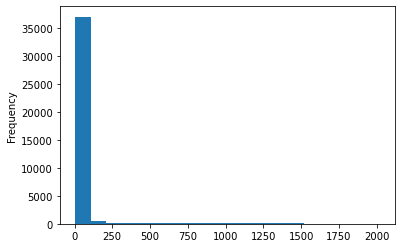

In [96]:
# visualizing 'cost' column
df['cost'].plot(kind='hist', bins=20)

In [97]:
df['cost'].describe()

count    38999.000000
mean        80.972210
std        180.715055
min          5.000000
25%         38.768742
50%         46.468476
75%         70.239797
max       2019.734797
Name: cost, dtype: float64

## Data Engineering

- Were there variables you dropped or created?
    - Dropped : 'exWeatherTag', 'type', 'packageType'
- How did you address missing values or outliers?
    - Kept outliers because they capture the full variability of my dataset without violating assumptions and skewing results
- Why are these choices appropriate given the data and the business problem?
    - They are appropriate in order for the model to be exposed to different data samples
- Can you pipeline your preparation steps to use them consistently in the modeling process?
    - Yes 

In [98]:
# exploring nans in different variables 

In [99]:
df['exWeatherTag'].value_counts()

snow    3286
heat    1596
Name: exWeatherTag, dtype: int64

In [100]:
df['type'].value_counts()

expedited    3748
Name: type, dtype: int64

In [101]:
df['packageType'].value_counts()

TT    2500
Name: packageType, dtype: int64

In [102]:
# dropping columns
clean_df = df.drop(columns=['exWeatherTag', 'type', 'packageType'])

In [103]:
# creating 'month' column 
clean_df['month'] = clean_df['date'].dt.month

### Train test split

In [104]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38999 entries, 0 to 38998
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   trip                 38999 non-null  object        
 1   date                 38999 non-null  datetime64[ns]
 2   dayPart              38999 non-null  object        
 3   originLocation       38999 non-null  object        
 4   destinationLocation  38999 non-null  object        
 5   distance             38999 non-null  int64         
 6   weight               38999 non-null  int64         
 7   carrier              38999 non-null  object        
 8   cost                 38999 non-null  float64       
 9   month                38999 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 3.0+ MB


In [105]:
X = clean_df.drop(columns=['trip','cost', 'date'])
y = clean_df['cost']

In [106]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size = .2)

In [107]:
y_train.describe()

count    31199.000000
mean        80.391868
std        178.244806
min          5.000000
25%         38.861952
50%         46.427799
75%         70.193598
max       2006.016001
Name: cost, dtype: float64

In [108]:
X_train.describe()

,distance,weight,month
count,31199.000000,31199.000000,31199.000000
mean,2003.987307,42.128241,6.494054
std,730.772599,75.062926,3.449203
min,400.000000,1.000000,1.000000
25%,1400.000000,13.000000,4.000000
50%,2000.000000,25.000000,6.000000
75%,2600.000000,39.000000,9.000000
max,3600.000000,500.000000,12.000000


### Pipeline

In [109]:
# pipeline for daypart, originlocation, destinationlocation, carrier, month
obj_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first'))
])

In [110]:
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

In [111]:
col_transformer = ColumnTransformer(transformers=[
    ('num_trans', num_transformer, ['distance', 'weight']),
    ('obj_trans', obj_transformer, ['dayPart', 'originLocation', 'destinationLocation', 'carrier', 'month'])
])

In [112]:
X_cols = list(X_train.columns)

In [123]:
X_cols

['dayPart',
 'originLocation',
 'destinationLocation',
 'distance',
 'weight',
 'carrier',
 'month']

In [126]:
pd.DataFrame(X_train, columns=X_train.columns)

,dayPart,originLocation,destinationLocation,distance,weight,carrier,month
12709,day,S5,D3,1600,3,B,1
37727,night,S7,D5,2400,3,D,10
31410,night,S5,D3,1600,45,D,10
13135,day,S8,D3,2200,33,B,6
34243,night,S2,D9,2200,3,B,7
...,...,...,...,...,...,...,...
6265,day,S9,D2,2200,49,B,10
11284,night,S8,D8,3200,7,B,1
38158,night,S1,D9,2000,34,B,5
860,night,S9,D9,3600,245,C,5


In [127]:
# creating X_col variable
X_cols = list(X_train.columns)

In [128]:
# turning columns from X_train into int
#for col in X_cols:
   # X_train[col] = X_train[col].astype(int)
   # X_test[col] = X_test[col].astype(int)

## Exploring relationship between two variables

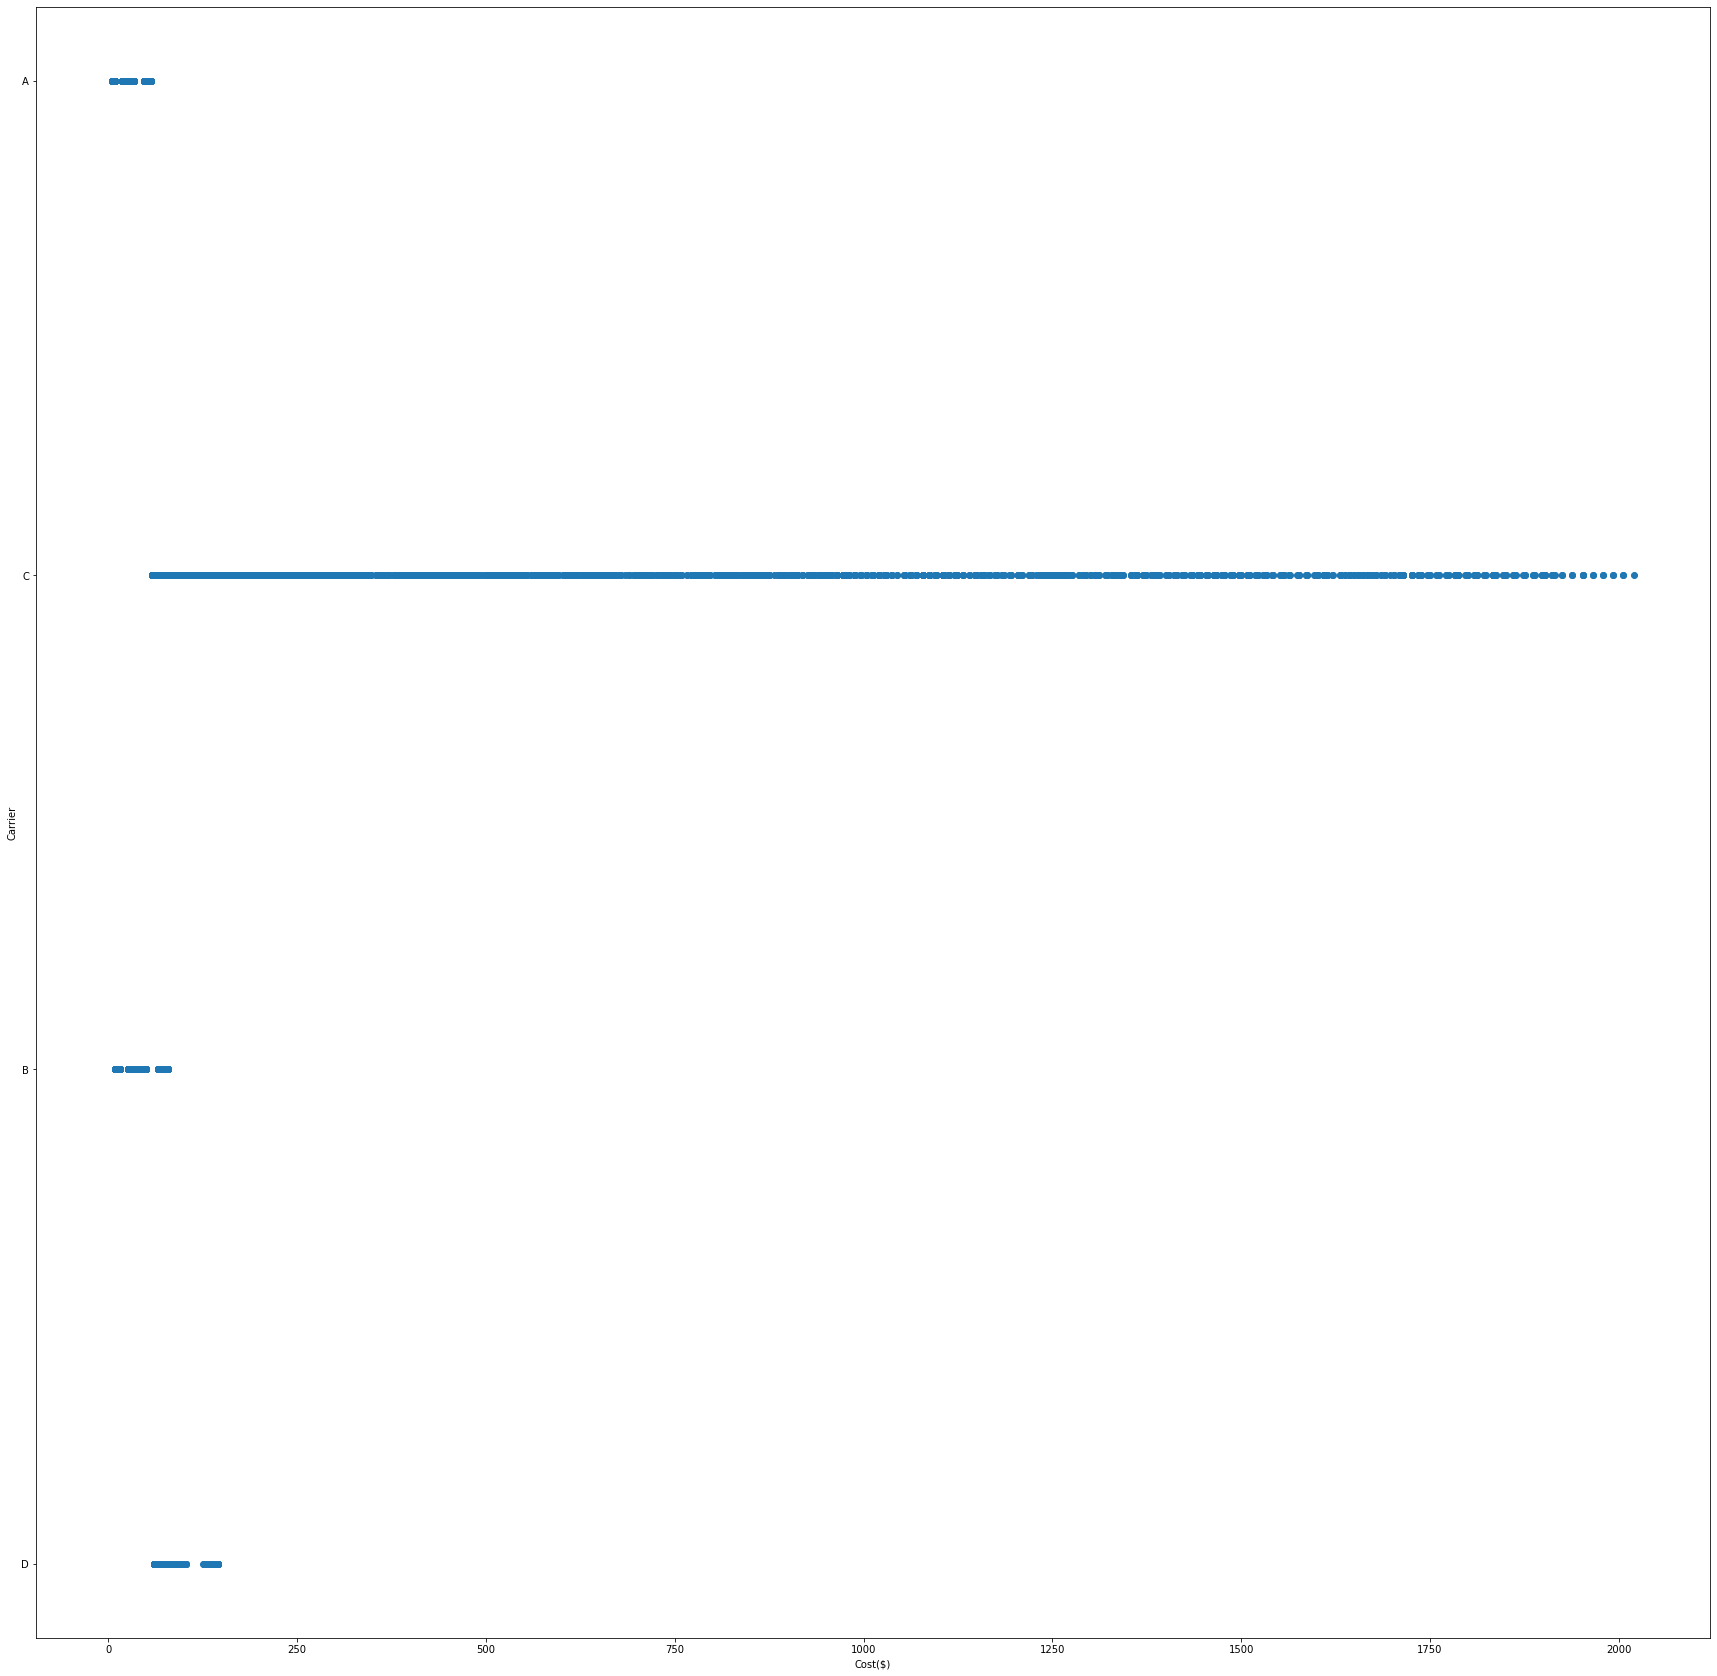

In [129]:
# can use a scatter plot to explore relationship between 'cost' and 'carrier'
plt.figure(figsize=(30,30))

plt.scatter(clean_df['cost'], clean_df['carrier'])
plt.ylabel('Carrier')
plt.xlabel('Cost($)')
plt.show()

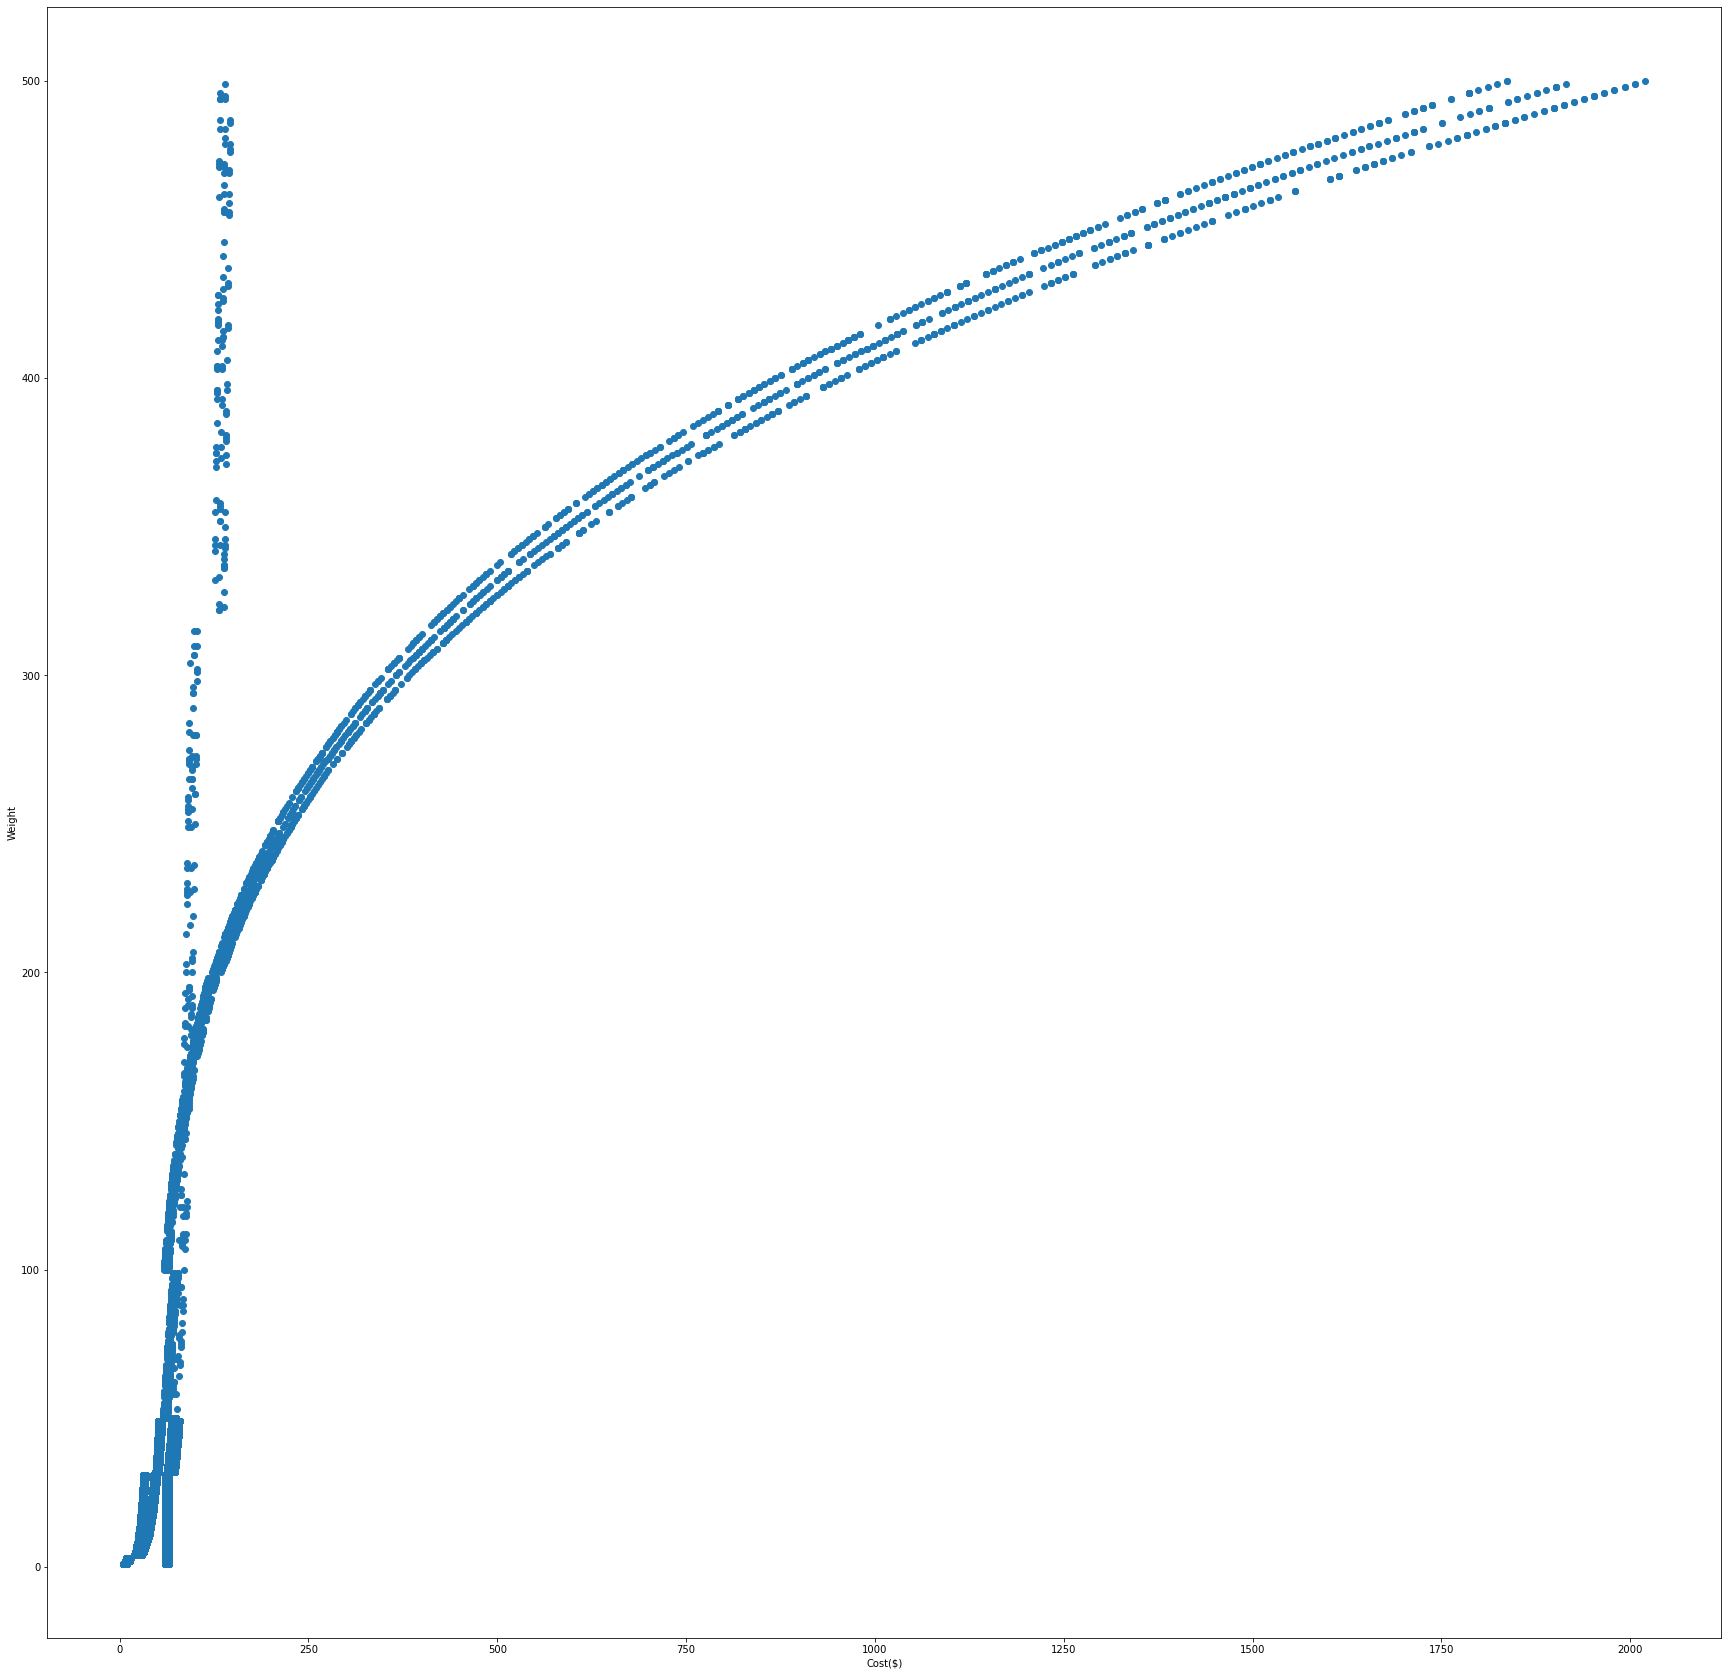

In [130]:
# can use a scatter plot to explore relationship between 'weight' and 'cost'
plt.figure(figsize=(30,30))

plt.scatter(clean_df['cost'], clean_df['weight'])
plt.ylabel('Weight')
plt.xlabel('Cost($)')
plt.show()

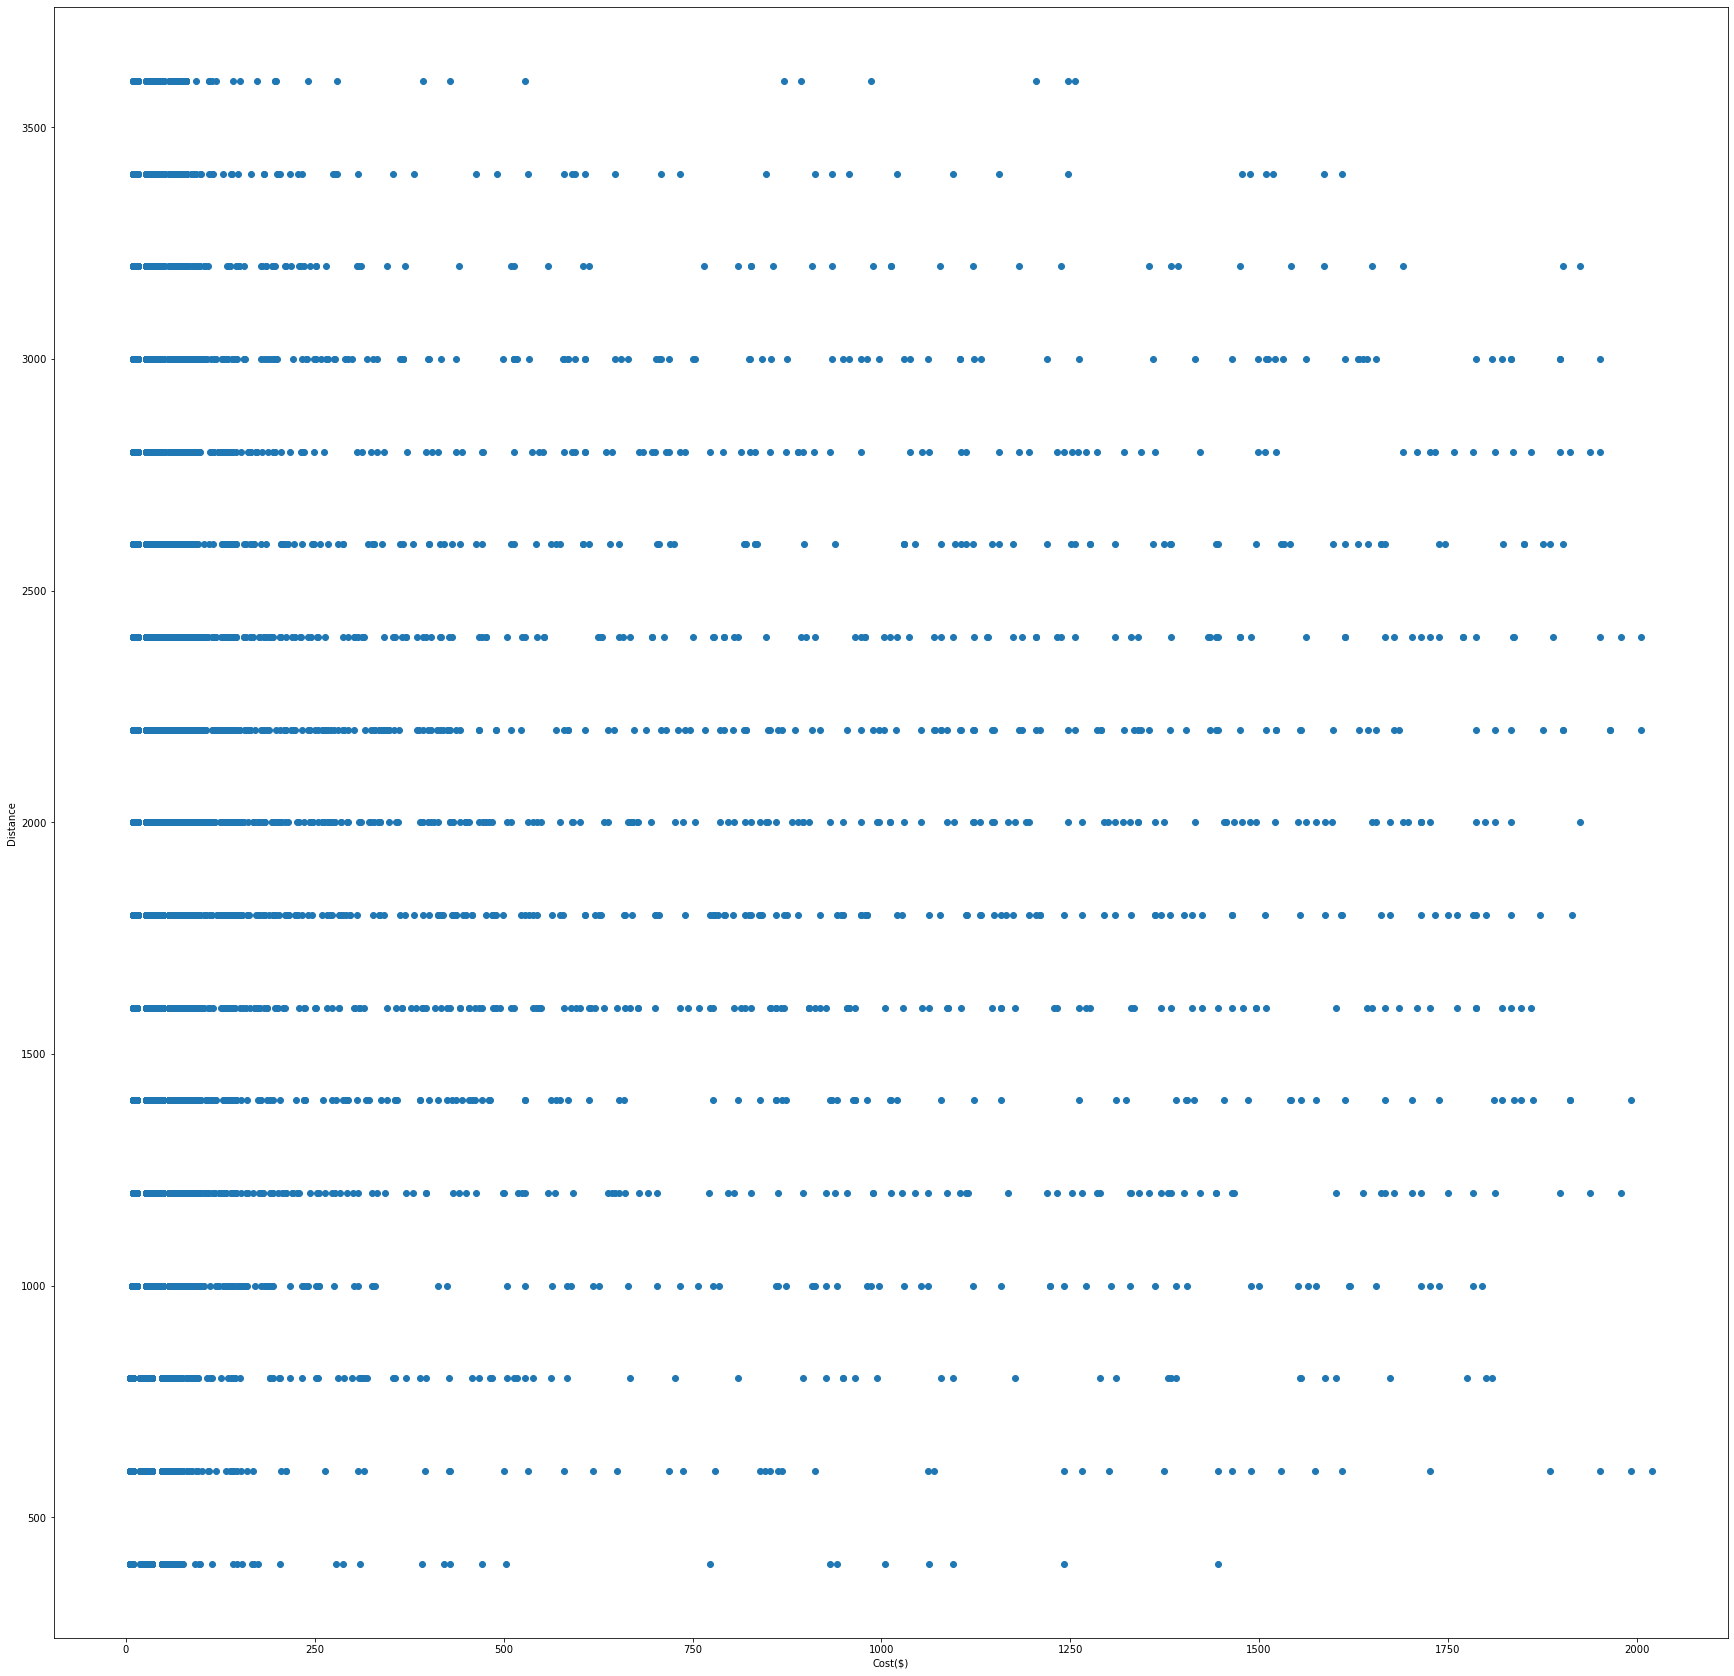

In [131]:
# can use a scatter plot to explore relationship 'cost' and 'distance'
plt.figure(figsize=(30,30))

plt.scatter(clean_df['cost'], clean_df['distance'])
plt.ylabel('Distance')
plt.xlabel('Cost($)')
plt.show()

### Baseline Understanding 

In [175]:
# What does a baseline, model-less prediction look like?
clean_df.head()

,trip,date,dayPart,originLocation,destinationLocation,distance,weight,carrier,cost,month
0,52712528,2017-09-06,night,S4,D7,2200,50,D,68.413152,9
1,29859381,2017-10-21,night,S8,D1,1800,12,B,36.450649,10
2,25702332,2017-07-15,night,S9,D5,2800,1,B,9.057939,7
3,27713405,2017-10-22,day,S9,D7,3200,50,C,57.320087,10
4,49439220,2019-12-11,day,S9,D1,2000,43,B,77.263777,12


## Modeling

Describe and justify the process for analyzing or modeling the data

- How will you iterate on your initial approach to make it better?
    - tune parametes
    - run GridSearchCV
- What model types are most appropriate, given the data and the business problem?
    - Linear regression 
    - Decision Tree

In [132]:
#checking correlations using Pearson correlation coefficient
X.corr()

,distance,weight,month
distance,1.000000,-0.004986,0.000988
weight,-0.004986,1.000000,-0.003634
month,0.000988,-0.003634,1.000000


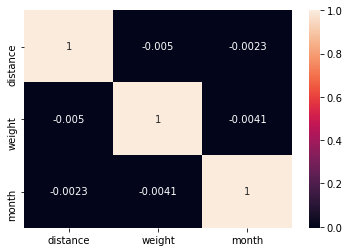

In [133]:
# Heat map
sns.heatmap(X_train.corr(), annot=True)
plt.show()

In [134]:
clean_df.corr()['cost'].map(abs).sort_values(ascending=False)

cost        1.000000
weight      0.859548
month       0.008062
distance    0.006427
Name: cost, dtype: float64

### Checking for linearity and multicollinearity 

In [ ]:
sns.pairplot(clean_df)
plt.show()

### Linear Regression 

In [ ]:
# Instantiate our model
lr_all = LinearRegression()

# Run with all features
lr_all.fit(X_train_sc, y_train)

# Score on train and test
print(f"Train R2: {lr_all.score(X_train_sc, y_train):.4f}")
print(f"Test R2: {lr_all.score(X_test_sc, y_test):.4f}")

### Linear regression - Pipeline

In [136]:
linreg_pipe = Pipeline(steps=[
    ('col_trans', col_transformer),
    ('linreg', LinearRegression())
])

In [137]:
linreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('num_trans',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['distance', 'weight']),
                                                 ('obj_trans',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['dayPart', 'originLocation',
                                                   'destinationLocation',
                                                   'carrier', 'month'])])),
                ('linreg', LinearRegression())])

In [138]:
y_hat_train = linreg_pipe.predict(X_train)
y_hat_test = linreg_pipe.predict(X_test)

In [139]:
# Evaluate: use .score to check accuracy on train and test
linreg_pipe.score(X_train, y_train)

0.7470071996878904

In [140]:
linreg_pipe.score(X_test, y_test)

0.7552069864234622

In [141]:
print(f'Train R2: {r2_score(y_train, y_hat_train)}')
print(f'Train RMSE: {mean_squared_error(y_train, y_hat_train, squared=False)}')
print('-------------------')
print(f'Test R2: {r2_score(y_test, y_hat_test)}')
print(f'Test RMSE: {mean_squared_error(y_test, y_hat_test, squared=False)}')

Train R2: 0.7470071996878904
Train RMSE: 89.65283026830319
-------------------
Test R2: 0.7552069864234622
Test RMSE: 94.13278154899274


### Decision Tree 1 - Pipeline

In [142]:
dt_pipe = Pipeline(steps=[
    ('col_trans', col_transformer),
    ('dt', DecisionTreeRegressor())
])

In [143]:
dt_pipe.fit(X_train, y_train)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('num_trans',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['distance', 'weight']),
                                                 ('obj_trans',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['dayPart', 'originLocation',
                                                   'destinationLocation',
                                                   'carrier', 'month'])])),
                ('dt', DecisionTreeRegressor())])

In [144]:
y_hat_train = dt_pipe.predict(X_train)
y_hat_test = dt_pipe.predict(X_test)

In [145]:
print(f'Train R2: {r2_score(y_train, y_hat_train)}')
print(f'Train RMSE: {mean_squared_error(y_train, y_hat_train, squared=False)}')
print('-------------------')
print(f'Test R2: {r2_score(y_test, y_hat_test)}')
print(f'Test RMSE: {mean_squared_error(y_test, y_hat_test, squared=False)}')

Train R2: 0.9999843558399417
Train RMSE: 0.7049950191686595
-------------------
Test R2: 0.9966716497226848
Test RMSE: 10.976298148075134


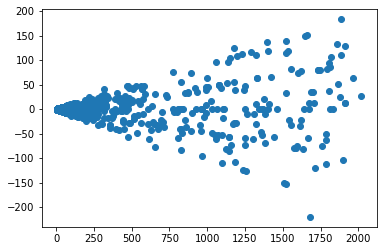

In [146]:
plt.scatter(y_test, (y_test - y_hat_test))

### Model Choice

### Decision Tree 2 - Pipeline

In [147]:
dt_pipe2 = Pipeline(steps=[
    ('col_trans', col_transformer),
    ('dt', DecisionTreeRegressor(max_depth=8))
])

In [148]:
dt_pipe2.fit(X_train, y_train)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('num_trans',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['distance', 'weight']),
                                                 ('obj_trans',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['dayPart', 'originLocation',
                                                   'destinationLocation',
                                                   'carrier', 'month'])])),
                ('dt', DecisionTreeRegressor(max_depth=8))])

In [149]:
y_hat_train = dt_pipe2.predict(X_train)
y_hat_test = dt_pipe2.predict(X_test)

In [150]:
print(f'Train R2: {r2_score(y_train, y_hat_train)}')
print(f'Train RMSE: {mean_squared_error(y_train, y_hat_train, squared=False)}')
print('-------------------')
print(f'Test R2: {r2_score(y_test, y_hat_test)}')
print(f'Test RMSE: {mean_squared_error(y_test, y_hat_test, squared=False)}')

Train R2: 0.9986328694405819
Train RMSE: 6.590447715371685
-------------------
Test R2: 0.997484202800746
Test RMSE: 9.542874165753734


### Random forest - Pipeline

In [151]:
rf_pipe = Pipeline(steps=[
    ('col_trans', col_transformer),
    ('rf', RandomForestRegressor())
])

In [152]:
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('num_trans',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['distance', 'weight']),
                                                 ('obj_trans',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['dayPart', 'originLocation',
                                                   'destinationLocation',
                                                   'carrier', 'month'])])),
                ('rf', RandomForestRegressor())])

In [153]:
y_hat_train = rf_pipe.predict(X_train)
y_hat_test = rf_pipe.predict(X_test)

In [154]:
print(f'Train R2: {r2_score(y_train, y_hat_train)}')
print(f'Train RMSE: {mean_squared_error(y_train, y_hat_train, squared=False)}')
print('-------------------')
print(f'Test R2: {r2_score(y_test, y_hat_test)}')
print(f'Test RMSE: {mean_squared_error(y_test, y_hat_test, squared=False)}')

Train R2: 0.9996822186718027
Train RMSE: 3.177416242781555
-------------------
Test R2: 0.9977120340962636
Test RMSE: 9.100518913323233


### GridSearch CV on Random Forest

In [155]:
gs_cv_pipe = Pipeline(steps=[
    ('col_trans', col_transformer),
    ('rf', RandomForestRegressor())
])

GridSearchCV

sklearn.model_selection._search.GridSearchCV

In [156]:
param_grid = {
    "rf__max_depth": [2,5,10],
    "rf__min_samples_leaf":[1,2,3,4],
    "rf__max_features" : [1, 'auto', 'sqrt']
}
gs = GridSearchCV(estimator=gs_cv_pipe, param_grid=param_grid)
gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('col_trans',
                                        ColumnTransformer(transformers=[('num_trans',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['distance',
                                                                          'weight']),
                                                                        ('obj_trans',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['dayPart',
                                                                          'originLocatio

In [157]:
# Checking out the best parameters
gs.best_params_

{'rf__max_depth': 10, 'rf__max_features': 'auto', 'rf__min_samples_leaf': 4}

In [158]:
# Checking out the best score
gs.best_score_

0.9978437471349496

In [159]:
# Checking out the best estimator
gs.best_estimator_

Pipeline(steps=[('col_trans',
                 ColumnTransformer(transformers=[('num_trans',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['distance', 'weight']),
                                                 ('obj_trans',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['dayPart', 'originLocation',
                                                   'destinationLocation',
                                                   'carrier', 'month'])])),
                ('rf',
                 RandomForestRegressor(max_depth=10, min_samples_leaf=4))])

In [ ]:
# Make predictions on the test set
y_hat_train = gs.best_estimator_.predict(X_train)
y_hat_test = gs.best_estimator_.predict(X_test)

In [ ]:
print(f'Train R2: {r2_score(y_train, y_hat_train)}')
print(f'Train RMSE: {mean_squared_error(y_train, y_hat_train, squared=False)}')
print('-------------------')
print(f'Test R2: {r2_score(y_test, y_hat_test)}')
print(f'Test RMSE: {mean_squared_error(y_test, y_hat_test, squared=False)}')

In [ ]:
print(gs_cv_pipe)

In [ ]:
### 'Final' Model

## Feature importance

In [161]:
feat_names= gs.best_estimator_.named_steps['col_trans'].named_transformers_['obj_trans']['ohe'].get_feature_names()

In [162]:
feat_imps = gs.best_estimator_.named_steps['rf'].feature_importances_

In [163]:
features = dict(zip(feat_names, feat_imps))

In [164]:
{k:v for k,v in sorted(features.items(), key=lambda x: x[1])}

{'x4_12': 2.100990481864609e-07,
 'x4_7': 5.238423032669411e-07,
 'x4_10': 9.89859984550893e-07,
 'x2_D3': 1.1254224195064643e-06,
 'x4_6': 1.5659772414940534e-06,
 'x4_11': 1.7671891415834203e-06,
 'x1_S5': 2.0971151796991866e-06,
 'x4_8': 2.2159038269275366e-06,
 'x4_5': 3.074346585316772e-06,
 'x4_4': 3.1987809443672943e-06,
 'x1_S6': 3.3942959006561005e-06,
 'x2_D8': 4.055314160290133e-06,
 'x1_S9': 5.2630288660281416e-06,
 'x2_D4': 6.887966635490333e-06,
 'x2_D5': 6.902504688178701e-06,
 'x1_S4': 7.697171796056225e-06,
 'x1_S8': 7.727447218753906e-06,
 'x2_D9': 8.639012594123759e-06,
 'x3_C': 8.980144345117938e-06,
 'x2_D7': 1.0615387351238898e-05,
 'x4_9': 1.0734857074257668e-05,
 'x1_S7': 1.1553444672724004e-05,
 'x2_D2': 1.4145283860612098e-05,
 'x2_D6': 1.738218546446945e-05,
 'x3_B': 1.983215856006913e-05,
 'x1_S3': 4.428790362162687e-05,
 'x3_D': 0.0001009809421748384,
 'x0_night': 0.0005376858959014309,
 'x4_2': 0.036353862689476844,
 'x4_3': 0.04466478864616702,
 'x1_S2': 

In [165]:
X_cols

['dayPart',
 'originLocation',
 'destinationLocation',
 'distance',
 'weight',
 'carrier',
 'month']

### Important features
- Time of Day
    - day 
    - night
- Origin Location / Destination Location
- Weight

## Exploring results on test set 

In [166]:
test_df = pd.read_csv('../data/test.csv', parse_dates=['date'])

In [167]:
test_df.head()

,trip,date,dayPart,exWeatherTag,originLocation,destinationLocation,distance,type,weight,packageType,carrier
0,t333282728025,2017-09-27,night,NaN,S2,D8,2000,NaN,50,NaN,C
1,t35583500660,2017-12-12,day,snow,S2,D1,600,NaN,22,NaN,A
2,t117664376784,2018-11-18,day,NaN,S7,D1,1600,expedited,30,NaN,D
3,t261320757828,2019-11-18,day,NaN,S5,D6,2200,NaN,32,NaN,B
4,t147086054909,2019-06-02,night,heat,S6,D7,2600,NaN,7,NaN,B


In [168]:
test_df['month'] = test_df['date'].dt.month

In [169]:
true_test_preds = gs.best_estimator_.predict(test_df[X_cols])

In [170]:
true_test_preds

array([  60.6054371 ,   30.78735838,   62.87434638,   70.01843824,
         33.29175251,   38.94947688,    9.22901491,   29.9864669 ,
         74.52907034,   44.48978916,   52.15442588,   29.9864669 ,
         74.52907034,   12.89953506,   47.16972356,   71.79101356,
        668.16506979,   45.50247495,   71.20988084,   41.62600383,
         74.52907034,   62.98614313,   24.79617013,   38.30696876,
         40.32143639,    8.77828384,   67.08658851,   22.93602829,
         21.30839639,   34.47936134,   88.40219843,   46.8505836 ,
         34.47936134, 1182.34146421,   33.29175251,    9.35206525,
         46.8505836 ,   46.1071236 ,   47.16972356,   62.91701531,
         75.34759888,   50.01301668,  175.67828171,   73.57836339,
         74.52907034,   75.33815147,   73.59976801,  329.94494312,
         70.50972544,   47.16268676,   60.52464757,   75.35568832,
         36.23997605,   70.50972544,   40.32143639,   70.39924089,
         41.11785936,   45.50247495,    7.59107648,   70.00902

<AxesSubplot:>

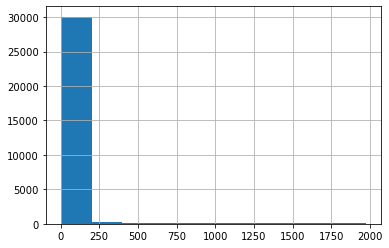

In [171]:
pd.Series(y_hat_train).hist()

<AxesSubplot:>

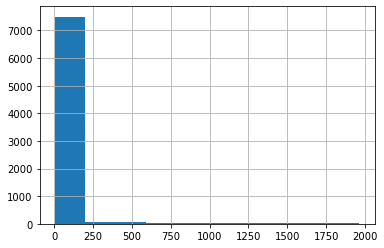

In [172]:
pd.Series(y_hat_test).hist()

<AxesSubplot:>

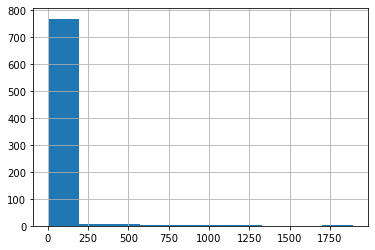

In [173]:
pd.Series(true_test_preds).hist()

### Evaluation 
- Accounting for 99% of cost 

## Box Plot 

Text(0.5, 1.0, 'Cost each month')

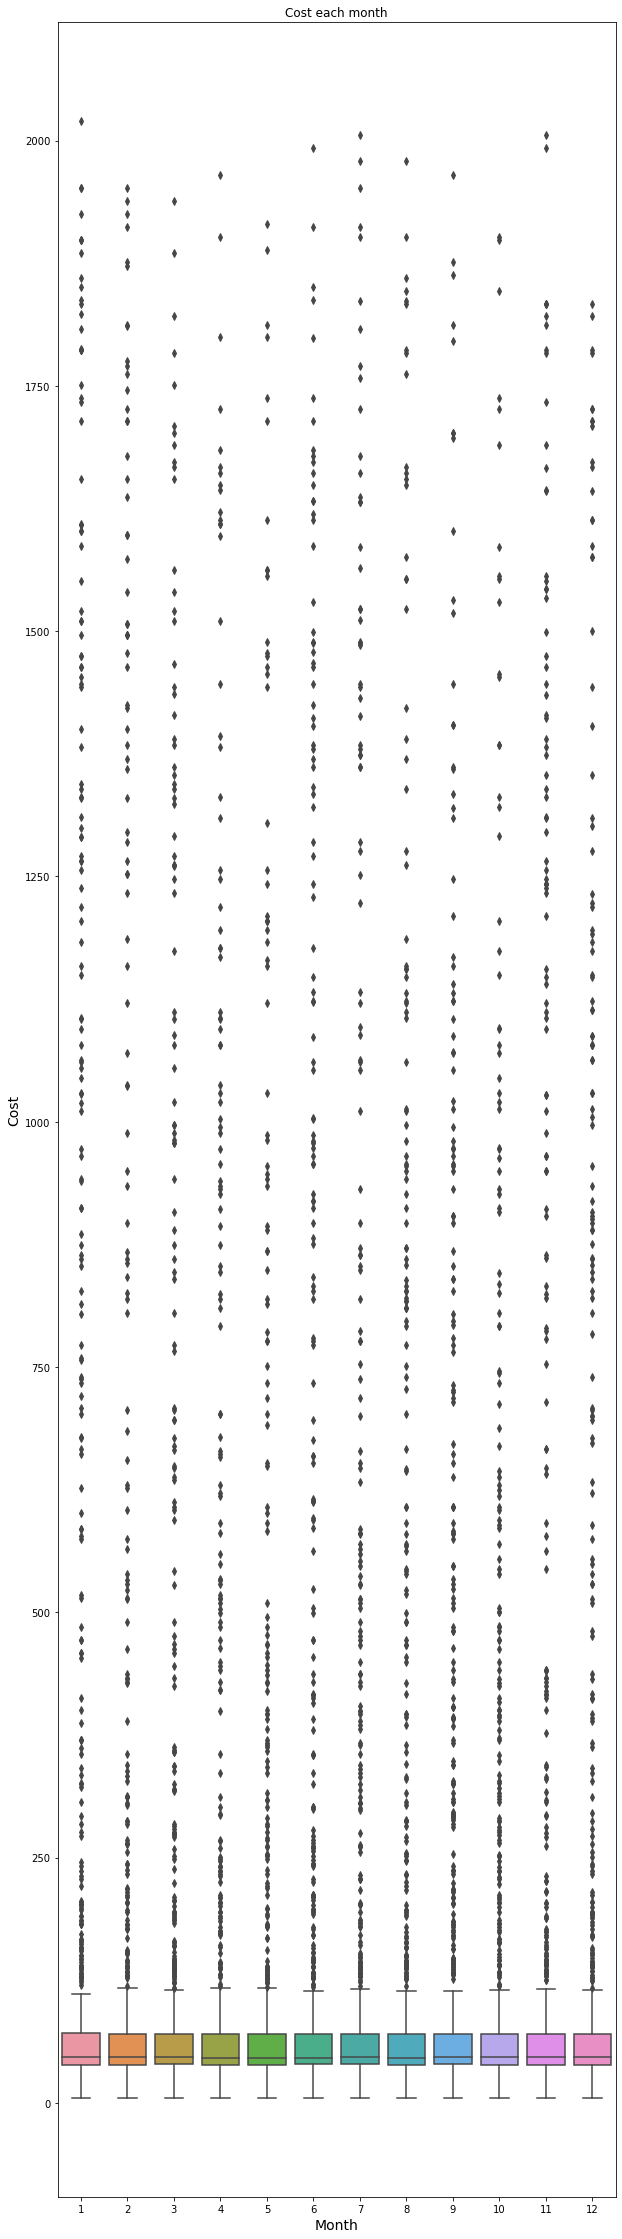

In [174]:
plt.figure(figsize=(10, 40))
sns.boxplot(x="month", 
            y="cost", 
            data=clean_df)
plt.ylabel("Cost", size=14)
plt.xlabel("Month", size=14)
plt.title("Cost each month")

## Conclusion

- What would you recommend the business do as a result of this work?
    - Optimizing time of day
    - Optimizing origin & destination location 
    - Shipments with least weight 
- What are some reasons why your analysis might not fully solve the business problem?
    - Outliers in data 
- What else could you do in the future to improve this project (future work)?
    - Dealing with outliers
    - Predicting costs for each month
    - Expected freight cost in a year